# check dataloader 

In [5]:
import gc
import os
import random
import time
import math

import cv2
import numpy as np
import matplotlib.pyplot as plt

# model
import torch
import torchvision
import torch.nn as nn
import timm
from torchvision.models.feature_extraction import create_feature_extractor
import torchvision.transforms.functional as TF

# data loader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader, Dataset

# training
from torch.optim import SGD, Adam, AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts, ReduceLROnPlateau, ExponentialLR, CyclicLR

# metric
from sklearn.metrics import fbeta_score, roc_auc_score

import wandb

import warnings
warnings.filterwarnings('ignore')

# config

In [6]:
BASE_DIR = "/working/"
INPUT_DIR = os.path.join(BASE_DIR, "input", "vesuvius-challenge-ink-detection")
TRAIN_DIR = os.path.join(INPUT_DIR, "train")
TEST_DIR = os.path.join(INPUT_DIR, "test")
# IMG_SIZE = [256, 256]
# IMG_SIZE = [128, 128]
IMG_SIZE = [512, 512]
SURFACE_LIST = [
                list(range(26, 36, 3)),
                list(range(27, 37, 3)),                
                list(range(25, 35, 3)),
                ]
print(len(SURFACE_LIST[0]))
print(SURFACE_LIST)

SURFACE_NUM = len(SURFACE_LIST[0])
# print("Start surface idx =",START_SURFACE)

# SLIDE_POS_LIST = [[idx*(IMG_SIZE[0]//6), idx*(IMG_SIZE[1]//6)] for idx in range(0, 3)]
SLIDE_POS_LIST = [[0,0], [IMG_SIZE[0]//2, 0], [0, IMG_SIZE[1]//2], [IMG_SIZE[0]//2, IMG_SIZE[1]//2]]
print("SLIDE_POS_LIST =", SLIDE_POS_LIST)
CFG = {
    "DEBUG" : False,
    # exp setting
    "EXP_CATEGORY" : "5fold",
    "EXP_NAME" : "exp038",
    "folds" : [0, 1, 2, 3, 4],

    # model
    # "model_name" : "tf_efficientnet_b2",
    "model_name" : "tf_efficientnet_b6",
    # "model_name" : "convnext_tiny",
    "inp_channels" : SURFACE_NUM,
    "out_channels" : 1,
    "pretrained" : True,
    # "out_indices" : [0,1,2,3,4],
    "out_indices": [0,1,2,3],
 
    # data   
    "img_size": IMG_SIZE,
    # "batch_size": 32,
    # "batch_size": 16,#batch normの関係か？16の方が64より安定してそう？？
    "batch_size": 8,
    "INPUT_DIR": INPUT_DIR,
    "TRAIN_DIR": TRAIN_DIR,
    "TEST_DIR": TEST_DIR,
    "surface_num": SURFACE_NUM,
    "surface_list": list(SURFACE_LIST),
    "slide_pos_list": SLIDE_POS_LIST,
    "RANDOM_SLIDE": True,
#     "surface_start_idx": START_SURFACE,
    # "TRAIN_DIR_LIST": [["1", "2"], ["1", "3"], ["2", "3"]],
    "TRAIN_DIR_LIST": [["1", "2_0", "2_1", "2_2"], 
                       ["1", "2_0", "2_1", "3"],
                       ["1", "2_0",  "2_2", "3"],
                       ["1", "2_1", "2_2", "3"],
                       ["2_0", "2_1", "2_2", "3"],
                       ],
#     "TRAIN_IDX_LIST" : ["1"],
    # "VALID_DIR_LIST": [["3"],["2"],["1"]],
    "VALID_DIR_LIST": [["3"], ["2_2"], ["2_1"], ["2_0"],["1"]],
    "TEST_DIR_LIST": ["a", "b"],

    # learning
    "n_epoch" : 15,
    "lr" : 1e-4,
    "T_max" : 5,
    "min_lr" : 1e-8,
    "weight_decay" : 1e-6,
    
    # cycliclr
    "step_size_up" : 5,
    "step_size_down" : 10,
    "max_lr" : 5e-4,
    "base_lr" : 5e-6,

    # etc
    "print_freq" : 1000,
    "random_seed" : 21,
    "num_workers": 2,
}


if CFG["model_name"]=="tf_efficientnet_b0":
    CFG["channel_nums"] = [320, 112, 40, 24, 16]
elif CFG["model_name"]=="tf_efficientnet_b2":
    CFG["channel_nums"] = [352, 120, 48, 24, 16]
elif CFG["model_name"]=="tf_efficientnet_b4":
    CFG["channel_nums"] = [448, 160, 56, 32, 24]
elif CFG["model_name"]=="tf_efficientnet_b6":
    # CFG["channel_nums"] = [576, 200, 72, 40, 32]
    CFG["channel_nums"] = [200, 72, 40, 32]
elif CFG["model_name"] == "convnext_tiny":
    CFG["channel_nums"] = [768, 384, 192, 96]


if CFG["DEBUG"]:
    CFG["n_epoch"] = 1
    CFG["EXP_NAME"] = "DEBUG"
    

CFG["OUTPUT_DIR"] = os.path.join(BASE_DIR, "output", CFG["EXP_NAME"])

4
[[26, 29, 32, 35], [27, 30, 33, 36], [25, 28, 31, 34]]
SLIDE_POS_LIST = [[0, 0], [256, 0], [0, 256], [256, 256]]


In [7]:
def seed_everything(seed=CFG["random_seed"]):
    #os.environ['PYTHONSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic =True
    torch.backends.cudnn.benchmark = False
seed_everything()

# device optimization
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(f'Using device: {device}')

Using device: cuda


In [8]:
def asMinutes(s):
    """Convert Seconds to Minutes."""
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    """Accessing and Converting Time Data."""
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))

class AverageMeter(object):
    """Computes and stores the average and current value."""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# metric

In [9]:
def fbeta_numpy(targets, preds, beta=0.5, smooth=1e-5):
    y_true_count = targets.sum()
    ctp = preds[targets==1].sum()
    cfp = preds[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

def calc_fbeta_auc(mask, mask_pred):
    mask = mask.astype(int).flatten()
    mask_pred = mask_pred.flatten()

    best_th = 0
    best_dice = 0
    dice_list = [] 
    # for th in np.array(range(10, 50+1, 5)) / 100:
    for th in np.array(range(10, 100+1, 5)) / 100:
        # dice = fbeta_score(mask, (mask_pred >= th).astype(int), beta=0.5)
        dice = fbeta_numpy(mask, (mask_pred >= th).astype(int), beta=0.5)
        dice_list.append(dice)
        # print(f'\t th: {th}, fbeta: {dice}')
        if dice > best_dice:
            best_dice = dice
            best_th = th
    
    auc = roc_auc_score(mask, mask_pred)
    # Logger.info(f'best_th: {best_th}, fbeta: {best_dice}')
    return best_dice, best_th, auc, dice_list


def calc_cv(mask_gt, mask_pred):
    best_dice, best_th, auc, dice_list = calc_fbeta_auc(mask_gt, mask_pred)

    return best_dice, best_th, auc, dice_list

# model

In [10]:
# class Encoder(nn.Module):
#     def __init__(self, CFG):
#         super().__init__()
#         self.encoder = timm.create_model(CFG["model_name"], in_chans=CFG["inp_channels"], features_only=True, out_indices=CFG["out_indices"], pretrained=CFG["pretrained"])
#     def forward(self, img):
#         skip_connection_list = self.encoder(img)
#         return skip_connection_list

# class UpConv(nn.Module):
#     def __init__(self, in_channels, out_channels):
#         super().__init__()
#         self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
#         self.bn1 = nn.BatchNorm2d(in_channels)
#         self.conv = nn.Conv2d(in_channels, out_channels, kernel_size = 2, padding="same")
#         self.bn2 = nn.BatchNorm2d(out_channels)

#     def forward(self, x):
#         x = self.up(x)
#         x = self.bn1(x)
#         x = self.conv(x)
#         x = self.bn2(x)
#         return x


# class Decoder(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.UpConv_0 = UpConv(CFG["channel_nums"][0], CFG["channel_nums"][1])
#         self.UpConv_1 = UpConv(CFG["channel_nums"][1]*2, CFG["channel_nums"][2])
#         self.UpConv_2 = UpConv(CFG["channel_nums"][2]*2, CFG["channel_nums"][3])
#         self.UpConv_3 = UpConv(CFG["channel_nums"][3]*2, CFG["channel_nums"][4])
#         # self.UpConv_4 = UpConv(CFG["channel_nums"][4]*2, CFG["channel_nums"][4])
    
#     def forward(self, skip_connection_list):
#         emb = self.UpConv_0(skip_connection_list[4]) # emb.shape = (None, 160, 14, 14)
#         emb_cat = torch.cat([skip_connection_list[3], emb], dim = 1)
        
#         emb = self.UpConv_1(emb_cat)
#         emb_cat = torch.cat([skip_connection_list[2], emb], dim = 1)
        
#         emb = self.UpConv_2(emb_cat)
#         emb_cat = torch.cat([skip_connection_list[1], emb], dim = 1)
        
#         emb = self.UpConv_3(emb_cat)
#         emb_cat = torch.cat([skip_connection_list[0], emb], dim = 1)

#         # emb_cat = self.UpConv_4(emb_cat)
        
#         return emb_cat

# class SegModel(nn.Module):
#     def __init__(self, CFG):
#         super().__init__()
#         self.encoder = Encoder(CFG)
#         self.decoder = Decoder()
#         self.head = nn.Sequential(
#             nn.Conv2d(CFG["channel_nums"][-1]*2, CFG["out_channels"], kernel_size=1, stride=1, padding=0),
#             # nn.Sigmoid()
#         )
#     def forward(self, img):
#         skip_connection_list = self.encoder(img)
#         emb = self.decoder(skip_connection_list)
#         output = self.head(emb)
#         assert output is not None, f"output is None, {img}, {skip_connection_list}, {emb}, {output}"
#         return output

In [11]:
class Encoder(nn.Module):
    def __init__(self, CFG):
        super().__init__()
        self.encoder = timm.create_model(CFG["model_name"], in_chans=CFG["inp_channels"], 
                                         features_only=True, out_indices=CFG["out_indices"], pretrained=CFG["pretrained"])
    def forward(self, img):
        skip_connection_list = self.encoder(img)
        return skip_connection_list

class UpConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size = 2, padding="same")
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.up(x)
        x = self.bn1(x)
        x = self.conv(x)
        x = self.bn2(x)
        return x

"""
下に２層を使わない
"""
# class Decoder(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.UpConv_0 = UpConv(CFG["channel_nums"][0], CFG["channel_nums"][1])
#         self.UpConv_1 = UpConv(CFG["channel_nums"][1]*2, CFG["channel_nums"][2])
#         self.UpConv_2 = UpConv(CFG["channel_nums"][2]*2, CFG["channel_nums"][2])
    
#     def forward(self, skip_connection_list):
#         emb = self.UpConv_0(skip_connection_list[2]) # emb.shape = (None, 160, 14, 14)
#         emb_cat = torch.cat([skip_connection_list[1], emb], dim = 1)
        
#         emb = self.UpConv_1(emb_cat)
#         emb_cat = torch.cat([skip_connection_list[0], emb], dim = 1)
        
#         return emb_cat

"""
下に1層を使わない
"""
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.UpConv_0 = UpConv(CFG["channel_nums"][0], CFG["channel_nums"][1])
        self.UpConv_1 = UpConv(CFG["channel_nums"][1]*2, CFG["channel_nums"][2])
        self.UpConv_2 = UpConv(CFG["channel_nums"][2]*2, CFG["channel_nums"][3])
        self.UpConv_3 = UpConv(CFG["channel_nums"][3]*2, CFG["channel_nums"][3])
    
    def forward(self, skip_connection_list):
        emb = self.UpConv_0(skip_connection_list[3]) # emb.shape = (None, 160, 14, 14)
        emb_cat = torch.cat([skip_connection_list[2], emb], dim = 1)
        
        emb = self.UpConv_1(emb_cat)
        emb_cat = torch.cat([skip_connection_list[1], emb], dim = 1)
        
        emb = self.UpConv_2(emb_cat)
        emb_cat = torch.cat([skip_connection_list[0], emb], dim = 1)
        
        return emb_cat
    
# class Decoder(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.UpConv_0 = UpConv(CFG["channel_nums"][0], CFG["channel_nums"][1])
#         self.UpConv_1 = UpConv(CFG["channel_nums"][1]*2, CFG["channel_nums"][2])
#         self.UpConv_2 = UpConv(CFG["channel_nums"][2]*2, CFG["channel_nums"][3])
#         self.UpConv_3 = UpConv(CFG["channel_nums"][3]*2, CFG["channel_nums"][4])
#         self.UpConv_4 = UpConv(CFG["channel_nums"][4]*2, CFG["channel_nums"][4])
    
#     def forward(self, skip_connection_list):
#         emb = self.UpConv_0(skip_connection_list[4]) # emb.shape = (None, 160, 14, 14)
#         emb_cat = torch.cat([skip_connection_list[3], emb], dim = 1)
        
#         emb = self.UpConv_1(emb_cat)
#         emb_cat = torch.cat([skip_connection_list[2], emb], dim = 1)
        
#         emb = self.UpConv_2(emb_cat)
#         emb_cat = torch.cat([skip_connection_list[1], emb], dim = 1)
        
#         emb = self.UpConv_3(emb_cat)
#         emb_cat = torch.cat([skip_connection_list[0], emb], dim = 1)

#         emb_cat = self.UpConv_4(emb_cat)
        
#         return emb_cat

class SegModel(nn.Module):
    def __init__(self, CFG):
        super().__init__()
        self.encoder = Encoder(CFG)
        self.decoder = Decoder()
        self.head = nn.Sequential(
            nn.Conv2d(CFG["channel_nums"][-1]*2, CFG["out_channels"], kernel_size=1, stride=1, padding=0),
            # nn.Sigmoid()
        )
    def forward(self, img):
        skip_connection_list = self.encoder(img)
        emb = self.decoder(skip_connection_list)
        output = self.head(emb)
#         output = TF.resize(img=output, size=(CFG["img_size"][0], CFG["img_size"][1]))
        return output

# Dataset

In [12]:
train_transforms = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomCrop(int(CFG["img_size"][0]*0.8), int(CFG["img_size"][1]*0.8), p=0.3),
    A.Blur(blur_limit=3, p=0.3),
    A.Resize(CFG["img_size"][0], CFG["img_size"][1]),
    ToTensorV2(),
])

valid_transforms = A.Compose([
    ToTensorV2(),
])

In [17]:
class VCID_Dataset(Dataset):
    def __init__(self, CFG, data_dir_list, surface_list, surface_volumes=None, slide_pos=[0,0], mode="train", transform=None):
        # get config
        self.mode = mode
        self.RANDOM_SLIDE = CFG["RANDOM_SLIDE"]
        self.img_size = CFG["img_size"]
        if self.mode=="train":  self.DATADIR = CFG["TRAIN_DIR"]
        elif self.mode=="valid":    self.DATADIR = CFG["TRAIN_DIR"]
        elif self.mode == "test":   self.DATADIR = CFG["TEST_DIR"]
        self.data_dir_list = data_dir_list
        self.surface_list = surface_list
        self.slide_pos = slide_pos
        self.transform = transform
        # get imgs
        # print("initializing dataset...")
        self.imgs = []
        for data_dir in self.data_dir_list:
            img_path = os.path.join(self.DATADIR, data_dir, "mask.png")
            # print(img_path)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = img.reshape(img.shape[0], img.shape[1], 1) # (h, w, channel=1)
            assert img is not None, "img is None. data path is wrong"
            self.imgs.append(img)  
        
        # get and split surface
        if surface_volumes is None:
            self.surface_vols = self.read_surfacevols()
        else:
            # print("using loaded surface_vols")
            self.surface_vols = surface_volumes
       
        # split grid
        self.get_all_grid()
        self.fileter_grid()
        self.get_flatten_grid()
        # print("split grid done.") 
       
        # get label imgs
        if self.mode == "train" or self.mode == "valid":
            self.labels = []
            for data_dir in self.data_dir_list:
                label_path = os.path.join(self.DATADIR, data_dir, "inklabels.png")
                assert os.path.exists(label_path), f"{label_path} is not exist."
                # read label
                label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)
                label = label.reshape(label.shape[0], label.shape[1], 1) # (h, w, channel=1)
                self.labels.append(label)# 画像サイズがそれぞれ違うので単純にconcatできずlist化しているs
        # print("initializing dataset done.")

    def get_surface_volumes(self):
        return self.surface_vols

    def read_surfacevols(self):
        """ read surface volume by data_dir_list and surface_list 
            Returns:surface_vuls (list): surface volume list [array(h,w,channel=surface_num), array(), ...]
        """
        surface_vols = []
        # print("reading surface volume...")
        for data_dir in self.data_dir_list:
            surface_vol_ = None
            for read_idx, surface_idx in enumerate(self.surface_list):
                # print("\r", f"reading idx : {read_idx+1}/{len(self.surface_list)}", end="")
                surface_path = os.path.join(self.DATADIR, data_dir, "surface_volume", f"{surface_idx:02}.tif")
                surface_vol_main = cv2.imread(surface_path, cv2.IMREAD_GRAYSCALE)
                print(surface_path)
                
                surface_path = os.path.join(self.DATADIR, data_dir, "surface_volume", f"{surface_idx-1:02}.tif")
                surface_vol_bef = cv2.imread(surface_path, cv2.IMREAD_GRAYSCALE)
                print(surface_path)
                
                surface_path = os.path.join(self.DATADIR, data_dir, "surface_volume", f"{surface_idx+1:02}.tif")
                surface_vol_aft = cv2.imread(surface_path, cv2.IMREAD_GRAYSCALE)
                print(surface_path)
                surface_vol = np.mean([surface_vol_bef, surface_vol_main, surface_vol_aft], axis=0)               
                print(surface_vol.shape)
                surface_vol = surface_vol.reshape(surface_vol.shape[0], surface_vol.shape[1], 1) # (h, w, channel=1)
                if surface_vol_ is None:
                    surface_vol_ = surface_vol
                else:
                    surface_vol_ = np.concatenate([surface_vol_, surface_vol], axis=2) # (h, w, channel=surface_num)
            surface_vols.append(surface_vol_)
            # print(f"  => read surface volume done. [{data_dir}]")
        return surface_vols


    def get_grid_img(self, img, grid_idx):
        """ crop grid img from original img"""
        img_grid = img[(grid_idx[0]*self.img_size[0]) + self.slide_pos[0] : ((grid_idx[0]+1)*self.img_size[0]) + self.slide_pos[0],
                        (grid_idx[1]*self.img_size[1]) + self.slide_pos[1] : ((grid_idx[1]+1)*self.img_size[1]) + self.slide_pos[1]]
        return img_grid
    
    def get_grid_img_and_mask(self, img, mask, grid_idx):
        """ crop grid img from original img"""
        if self.RANDOM_SLIDE and self.mode=="train" and random.random() < 0.5:
            if (grid_idx[0]!=0 and grid_idx[1]!=0) and (grid_idx[0]!=img.shape[0]//self.img_size[0] and grid_idx[1]!=img.shape[1]//self.img_size[1]):
                rand_pos = [np.random.randint(0, self.img_size[0]//4) - self.img_size[0]//4, np.random.randint(0, self.img_size[1]//4)-self.img_size[1]//4]
            else:
                rand_pos = [0, 0]
        else:
            rand_pos = [0, 0]
        self.rand_pos = rand_pos
        img_grid = img[(grid_idx[0]*self.img_size[0]) + self.slide_pos[0] + rand_pos[0] : ((grid_idx[0]+1)*self.img_size[0]) + self.slide_pos[0] + rand_pos[0],
                        (grid_idx[1]*self.img_size[1]) + self.slide_pos[1] + rand_pos[1] : ((grid_idx[1]+1)*self.img_size[1]) + self.slide_pos[1] + rand_pos[1]]
        mask_grid = mask[(grid_idx[0]*self.img_size[0]) + self.slide_pos[0] + rand_pos[0] : ((grid_idx[0]+1)*self.img_size[0]) + self.slide_pos[0] + rand_pos[0],
                         (grid_idx[1]*self.img_size[1]) + self.slide_pos[1] + rand_pos[1] : ((grid_idx[1]+1)*self.img_size[1]) + self.slide_pos[1] + rand_pos[1]]
        return img_grid/255., mask_grid/255.
    
    def get_masked_img(self, img, mask):
        """ multiply mask to surface_volumes """
        masked_img = None
        for channel in range(img.shape[2]):
            img_channel = img[:,:,channel].reshape(img.shape[0], img.shape[1],1)
            masked = img_channel*mask
            if masked_img is None:
                masked_img = masked.reshape(masked.shape[0], masked.shape[1], 1)
            else:
                masked = masked.reshape(masked.shape[0], masked.shape[1], 1)
                masked_img = np.concatenate([masked_img, masked], axis=2)
        return masked_img
    
    
    def get_all_grid(self):
        """ get all grid indices by img size and grid size
        """
        self.grid_indices = []
        for img in self.imgs:
            self.x_grid_size = (img.shape[0] - self.slide_pos[0]) // self.img_size[0]
            self.y_grid_size = (img.shape[1] - self.slide_pos[1]) // self.img_size[1]
            grid_img = []
            for i in range(self.x_grid_size):
                for j in range(self.y_grid_size):
                    grid_img.append([i, j])
            self.grid_indices.append(grid_img)
        return self.grid_indices
          
    def fileter_grid(self):
        """ get grid indices which mask is not 0 by all grid indices"""
        grid_indices_all = []
        for img, grid_indices in zip(self.imgs, self.grid_indices):
            grid_indices_copy = grid_indices.copy()
            for grid_idx in grid_indices:
                img_grid = self.get_grid_img(img, grid_idx)
                if img_grid.sum() == 0:
                    grid_indices_copy.remove(grid_idx)
            grid_indices_all.append(grid_indices_copy)
        self.grid_indices = grid_indices_all
        return self.grid_indices

    def get_flatten_grid(self):
        """ get flatten index list by grid indices
            Returns:flatten_grid (list): flatten index list [[img_idx, grid_idx], [img_idx, grid_idx], ...]
        """
        flatten_grid = []
        for img_idx, grid_indices in enumerate(self.grid_indices):
            for grid_idx in grid_indices:
                grid_imgidx_list = [img_idx]
                grid_imgidx_list.extend(grid_idx)
                flatten_grid.append(grid_imgidx_list)
        self.flatten_grid = flatten_grid
        return self.flatten_grid
    
    def channel_shuffle(self, img):
        img = img.transpose(2, 0, 1)
        np.random.shuffle(img)
        return img.transpose(1, 2, 0)

    def __len__(self):
        return len(self.flatten_grid)

    def __getitem__(self, idx):
        # get indices
        img_grid_idx = self.flatten_grid[idx]
        img_idx = img_grid_idx[0]
        grid_idx = img_grid_idx[1:]
        # get img & surface_vol
        mask = self.imgs[img_idx]
        surface_vol = self.surface_vols[img_idx]
        # mask = self.get_grid_img(mask, grid_idx)/255.
        # surface_vol = self.get_grid_img(surface_vol, grid_idx)/255.
        mask, surface_vol = self.get_grid_img_and_mask(mask, surface_vol, grid_idx)
        # multiple small mask 
        assert surface_vol.shape[0]==mask.shape[0] and surface_vol.shape[1]==mask.shape[1] , "surface_vol_list shape is not same as img shape"
        img = surface_vol
        # transform
        if self.mode == "test":
            if self.transform:
                img = self.transform(image=img)["image"]
            else:
                img = img.transpose(2, 0, 1)
                img = torch.tensor(img, dtype=torch.float32)
            return img, grid_idx
        elif self.mode == "train" or self.mode=="valid":
            # get label(segmentation mask)
            label = self.labels[img_idx]
            label = self.get_grid_img(label, grid_idx)
            # if self.mode == "train":
            #     img = self.channel_shuffle(img)
            if self.transform:
                transformed = self.transform(image=img, mask=label)
                img = transformed["image"]
                label = transformed["mask"]
                label = label.permute(2, 0, 1)/255. # (channel, h, w)
                # label = TF.resize(img=label, size=(self.img_size[0]//2, self.img_size[1]//2))
            else:
                img = img.transpose(2, 0, 1) # (channel, h, w)
                label = label.transpose(2, 0, 1)/255. # (channel, h, w){}
                img = torch.tensor(img, dtype=torch.float32)
                label = torch.tensor(label, dtype=torch.float32)
                # label = TF.resize(img=label, size=(self.img_size[0]//2, self.img_size[1]//2))
            assert img is not None and label is not None, f"img or label is None {img} {label}, {img_idx}, {grid_idx}, {self.rand_pos}"
            return img, label, grid_idx

dataset
/working/input/vesuvius-challenge-ink-detection/train/3/surface_volume/26.tif
/working/input/vesuvius-challenge-ink-detection/train/3/surface_volume/25.tif
/working/input/vesuvius-challenge-ink-detection/train/3/surface_volume/27.tif
(7606, 5249)
/working/input/vesuvius-challenge-ink-detection/train/3/surface_volume/29.tif
/working/input/vesuvius-challenge-ink-detection/train/3/surface_volume/28.tif
/working/input/vesuvius-challenge-ink-detection/train/3/surface_volume/30.tif
(7606, 5249)
/working/input/vesuvius-challenge-ink-detection/train/3/surface_volume/32.tif
/working/input/vesuvius-challenge-ink-detection/train/3/surface_volume/31.tif
/working/input/vesuvius-challenge-ink-detection/train/3/surface_volume/33.tif
(7606, 5249)
/working/input/vesuvius-challenge-ink-detection/train/3/surface_volume/35.tif
/working/input/vesuvius-challenge-ink-detection/train/3/surface_volume/34.tif
/working/input/vesuvius-challenge-ink-detection/train/3/surface_volume/36.tif
(7606, 5249)
data

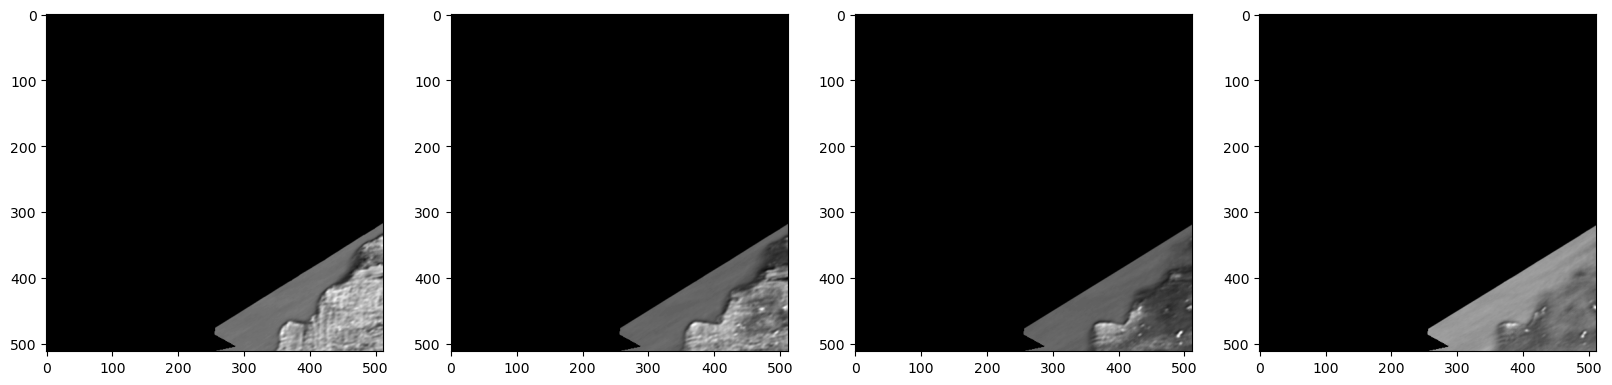

0.875817
0.98300654
0.99346405
0.6509804


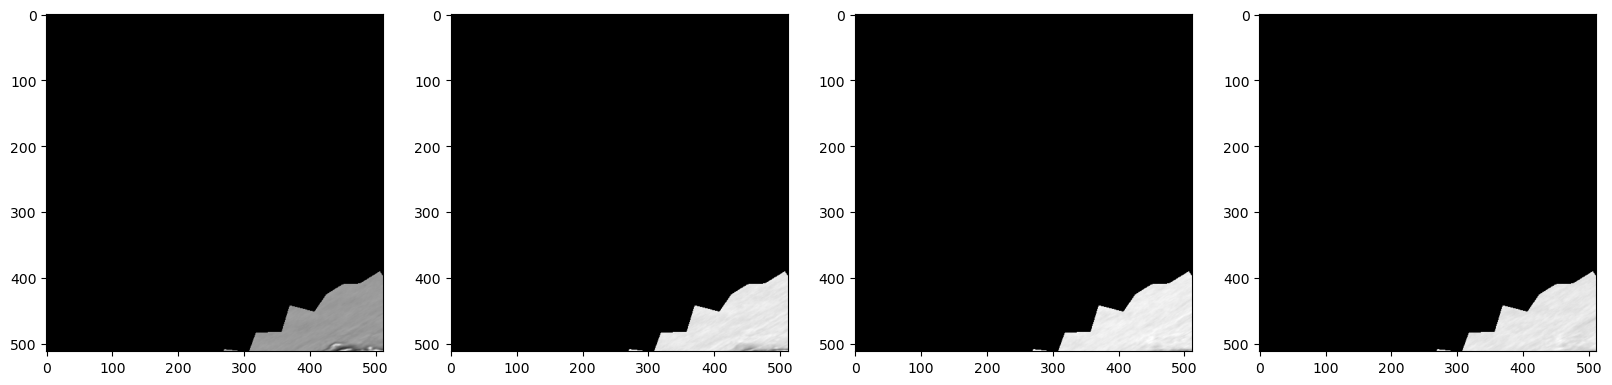

0.64444447
0.43267974
0.42091504
0.43267974


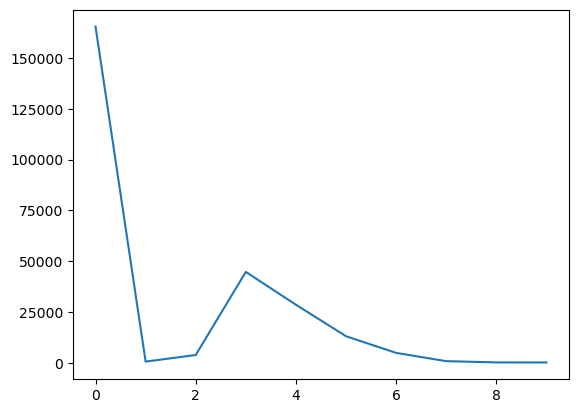

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.3804, 0.3686, 0.3582],
        [0.0000, 0.0000, 0.0000,  ..., 0.3699, 0.3595, 0.3582],
        [0.0000, 0.0000, 0.0000,  ..., 0.3660, 0.3634, 0.3634],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.5007, 0.4588, 0.4092],
        [0.0000, 0.0000, 0.0000,  ..., 0.5020, 0.4693, 0.3948],
        [0.0000, 0.0000, 0.0000,  ..., 0.5072, 0.4392, 0.3974]])


In [18]:
valid_dirs = CFG["VALID_DIR_LIST"][0]
surface_list = SURFACE_LIST[0]
print("dataset")
dataset_notrans = VCID_Dataset(CFG, valid_dirs, surface_list, mode="train")
surface_volumes = dataset_notrans.surface_vols
print("dataloader")
dataloader_notrans = DataLoader(dataset_notrans, 4, shuffle=False, num_workers=0)

imshow_batch = 10

for batch_idx, (imgs, labels, grid_idx) in enumerate(dataloader_notrans):
    img = imgs[0].permute(1, 2, 0)
    if batch_idx < 2:
        plt.figure(figsize=(20,5))
        for channel in range(img.shape[2]):
            plt.subplot(1, img.shape[2], channel+1)
            plt.imshow(img[:,:,channel], cmap="gray")
        plt.show()
        [print(np.max(img[:,:,idx].numpy())) for idx in range(img.shape[2])]
        
    if batch_idx >= imshow_batch:
        break    

img_hist, img_bins = np.histogram(np.array(img[:,:,0]).flatten())
plt.figure()
plt.plot(img_hist)
plt.show()
print(img[:,:,0])


dataset
/working/input/vesuvius-challenge-ink-detection/train/3/surface_volume/26.tif
/working/input/vesuvius-challenge-ink-detection/train/3/surface_volume/25.tif
/working/input/vesuvius-challenge-ink-detection/train/3/surface_volume/27.tif
(7606, 5249)
/working/input/vesuvius-challenge-ink-detection/train/3/surface_volume/29.tif
/working/input/vesuvius-challenge-ink-detection/train/3/surface_volume/28.tif
/working/input/vesuvius-challenge-ink-detection/train/3/surface_volume/30.tif
(7606, 5249)
/working/input/vesuvius-challenge-ink-detection/train/3/surface_volume/32.tif
/working/input/vesuvius-challenge-ink-detection/train/3/surface_volume/31.tif
/working/input/vesuvius-challenge-ink-detection/train/3/surface_volume/33.tif
(7606, 5249)
/working/input/vesuvius-challenge-ink-detection/train/3/surface_volume/35.tif
/working/input/vesuvius-challenge-ink-detection/train/3/surface_volume/34.tif
/working/input/vesuvius-challenge-ink-detection/train/3/surface_volume/36.tif
(7606, 5249)
data

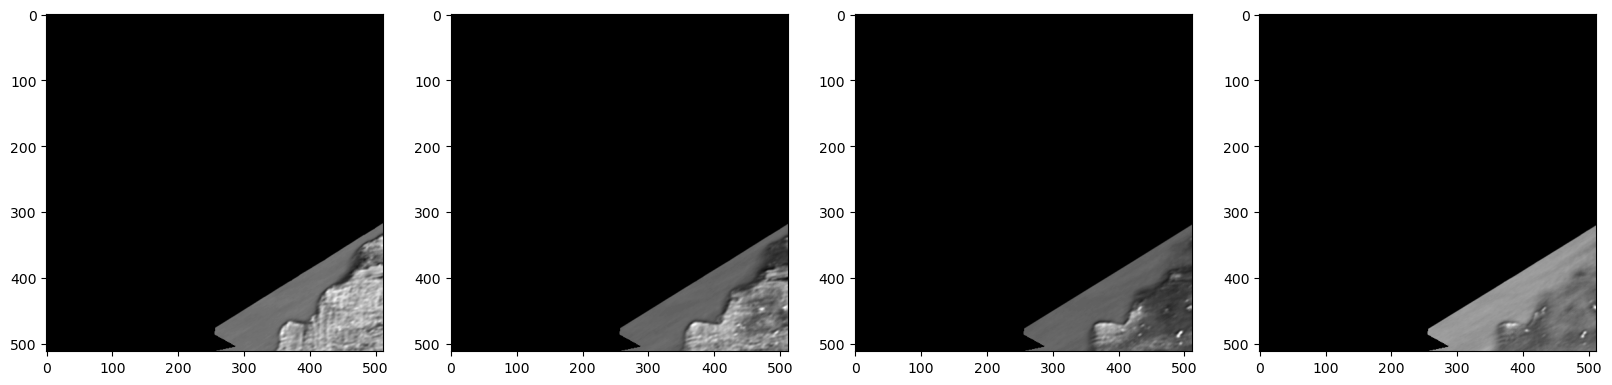

0.8758169934640523
0.9830065359477124
0.9934640522875817
0.6509803921568628


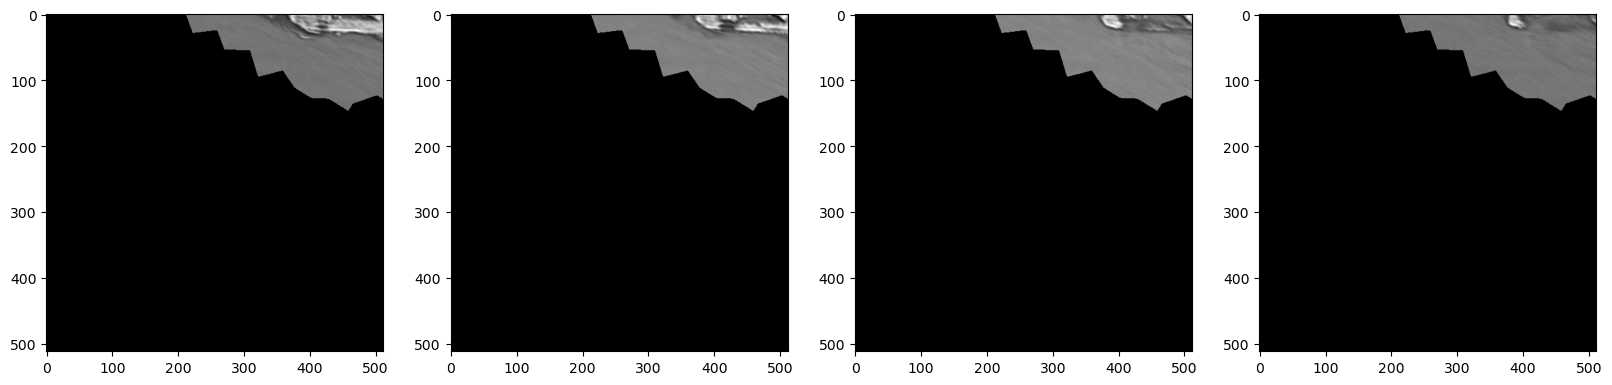

0.8549019607843137
0.7738562091503268
0.7529411764705882
0.8444444444444444


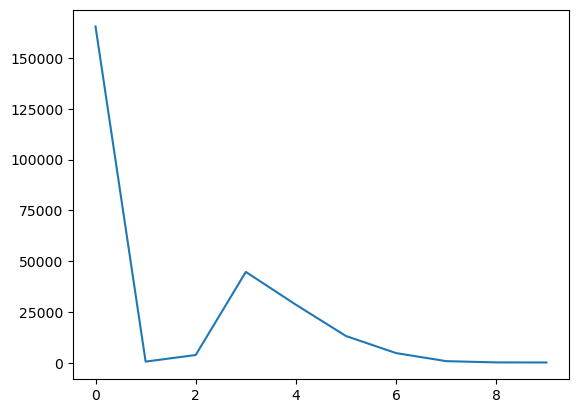

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.3804, 0.3686, 0.3582],
        [0.0000, 0.0000, 0.0000,  ..., 0.3699, 0.3595, 0.3582],
        [0.0000, 0.0000, 0.0000,  ..., 0.3660, 0.3634, 0.3634],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.5007, 0.4588, 0.4092],
        [0.0000, 0.0000, 0.0000,  ..., 0.5020, 0.4693, 0.3948],
        [0.0000, 0.0000, 0.0000,  ..., 0.5072, 0.4392, 0.3974]],
       dtype=torch.float64)


In [22]:
valid_dirs = CFG["VALID_DIR_LIST"][0]
surface_list = SURFACE_LIST[0]
print("dataset")
dataset = VCID_Dataset(CFG, valid_dirs, surface_list, mode="train", transform=train_transforms)
surface_volumes = dataset.surface_vols
print("dataloader")
dataloader = DataLoader(dataset, 4, shuffle=False, num_workers=0)

imshow_batch = 10

for batch_idx, (imgs, labels, grid_idx) in enumerate(dataloader):
    img = imgs[0].permute(1, 2, 0)
    if batch_idx < 2:
        plt.figure(figsize=(20,5))
        for channel in range(img.shape[2]):
            plt.subplot(1, img.shape[2], channel+1)
            plt.imshow(img[:,:,channel], cmap="gray")
        plt.show()
        [print(np.max(img[:,:,idx].numpy())) for idx in range(img.shape[2])]
    if batch_idx >= imshow_batch:
        break    

img_hist, img_bins = np.histogram(np.array(img[:,:,0]).flatten())
plt.figure()
plt.plot(img_hist)
plt.show()
print(img[:,:,0])


In [ ]:
# print("dataset")
# dataset_notrans = VCID_Dataset(CFG, valid_dirs, surface_list, surface_volumes, slide_pos=[0,50],mode="train")
# print("dataloader")
# dataloader_notrans = DataLoader(dataset_notrans, 4, shuffle=False, num_workers=0)

# imshow_batch = 10

# for batch_idx, (imgs, labels, grid_idx) in enumerate(dataloader_notrans):
#     img = imgs[0].permute(1, 2, 0)
#     if batch_idx == 1:
#         plt.figure(figsize=(20,5))
#         for channel in range(img.shape[2]):
#             plt.subplot(1, img.shape[2], channel+1)
#             plt.imshow(img[:,:,channel], cmap="gray")
#         plt.show()
#         [print(np.max(img[:,:,idx].numpy())) for idx in range(img.shape[2])]
#     if batch_idx >= imshow_batch:
#         break    

# img_hist, img_bins = np.histogram(np.array(img[:,:,0]).flatten())
# plt.figure()
# plt.plot(img_hist)
# plt.show()
# print(img[:,:,0])


In [ ]:
# valid_dirs = CFG["VALID_DIR_LIST"][0]
# surface_list = SURFACE_LIST[0]
# print("dataset")
# dataset_notrans = VCID_Dataset(CFG, valid_dirs, surface_list, mode="train", transform=train_transforms)
# print("dataloader")
# dataloader_notrans = DataLoader(dataset_notrans, 4, shuffle=False, num_workers=0)


# imshow_batch = 10

# for batch_idx, (imgs, labels, grid_idx) in enumerate(dataloader_notrans):
#     img = imgs[0].permute(1, 2, 0)
#     if batch_idx == 0:
#         plt.figure(figsize=(20,5))
#         for channel in range(img.shape[2]):
#             plt.subplot(1, img.shape[2], channel+1)
#             plt.imshow(img[:,:,channel], cmap="gray")
#         plt.show()
#         [print(np.max(img[:,:,idx].numpy())) for idx in range(img.shape[2])]
#     if batch_idx >= imshow_batch:
#         break    

# img_hist, img_bins = np.histogram(np.array(img[:,:,0]).flatten())
# plt.figure()
# plt.plot(img_hist)
# plt.show()
# print(img[:,:,0])